In [27]:
# Import
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import cartopy.crs as crss
import cartopy.feature as cfeat
import cartopy.io.shapereader as shpreader

sns.set(style="ticks")
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read dataset
df = pd.read_csv("coffee-quality-database-master/data/arabica_data_cleaned.csv")

In [3]:
# Look at first entries
df.head()

,Unnamed: 0,Species,Owner,Country.of.Origin,Farm.Name,Lot.Number,Mill,ICO.Number,Company,Altitude,...,Color,Category.Two.Defects,Expiration,Certification.Body,Certification.Address,Certification.Contact,unit_of_measurement,altitude_low_meters,altitude_high_meters,altitude_mean_meters
0,1,Arabica,metad plc,Ethiopia,metad plc,NaN,metad plc,2014/2015,metad agricultural developmet plc,1950-2200,...,Green,0,"April 3rd, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1950.0,2200.0,2075.0
1,2,Arabica,metad plc,Ethiopia,metad plc,NaN,metad plc,2014/2015,metad agricultural developmet plc,1950-2200,...,Green,1,"April 3rd, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1950.0,2200.0,2075.0
2,3,Arabica,grounds for health admin,Guatemala,"san marcos barrancas ""san cristobal cuch",NaN,NaN,NaN,NaN,1600 - 1800 m,...,NaN,0,"May 31st, 2011",Specialty Coffee Association,36d0d00a3724338ba7937c52a378d085f2172daa,0878a7d4b9d35ddbf0fe2ce69a2062cceb45a660,m,1600.0,1800.0,1700.0
3,4,Arabica,yidnekachew dabessa,Ethiopia,yidnekachew dabessa coffee plantation,NaN,wolensu,NaN,yidnekachew debessa coffee plantation,1800-2200,...,Green,2,"March 25th, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1800.0,2200.0,2000.0
4,5,Arabica,metad plc,Ethiopia,metad plc,NaN,metad plc,2014/2015,metad agricultural developmet plc,1950-2200,...,Green,2,"April 3rd, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1950.0,2200.0,2075.0


In [4]:
# Look at descriptions
print(df.info())
print("\n", df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1311 entries, 0 to 1310
Data columns (total 44 columns):
Unnamed: 0               1311 non-null int64
Species                  1311 non-null object
Owner                    1304 non-null object
Country.of.Origin        1310 non-null object
Farm.Name                955 non-null object
Lot.Number               270 non-null object
Mill                     1001 non-null object
ICO.Number               1165 non-null object
Company                  1102 non-null object
Altitude                 1088 non-null object
Region                   1254 non-null object
Producer                 1081 non-null object
Number.of.Bags           1311 non-null int64
Bag.Weight               1311 non-null object
In.Country.Partner       1311 non-null object
Harvest.Year             1264 non-null object
Grading.Date             1311 non-null object
Owner.1                  1304 non-null object
Variety                  1110 non-null object
Processing.Method      

In [5]:
# Experimental removal of unneeded information and transformation of the necessary when needed.
df = df.drop(['Altitude', 'Lot.Number', 'Number.of.Bags', 'Bag.Weight', 
              'Owner', 'Certification.Address', 'Certification.Contact', "Unnamed: 0"], axis=1)

In [6]:
df.head(10)

,Species,Country.of.Origin,Farm.Name,Mill,ICO.Number,Company,Region,Producer,In.Country.Partner,Harvest.Year,...,Category.One.Defects,Quakers,Color,Category.Two.Defects,Expiration,Certification.Body,unit_of_measurement,altitude_low_meters,altitude_high_meters,altitude_mean_meters
0,Arabica,Ethiopia,metad plc,metad plc,2014/2015,metad agricultural developmet plc,guji-hambela,METAD PLC,METAD Agricultural Development plc,2014,...,0,0.0,Green,0,"April 3rd, 2016",METAD Agricultural Development plc,m,1950.0,2200.0,2075.0
1,Arabica,Ethiopia,metad plc,metad plc,2014/2015,metad agricultural developmet plc,guji-hambela,METAD PLC,METAD Agricultural Development plc,2014,...,0,0.0,Green,1,"April 3rd, 2016",METAD Agricultural Development plc,m,1950.0,2200.0,2075.0
2,Arabica,Guatemala,"san marcos barrancas ""san cristobal cuch",NaN,NaN,NaN,NaN,NaN,Specialty Coffee Association,NaN,...,0,0.0,NaN,0,"May 31st, 2011",Specialty Coffee Association,m,1600.0,1800.0,1700.0
3,Arabica,Ethiopia,yidnekachew dabessa coffee plantation,wolensu,NaN,yidnekachew debessa coffee plantation,oromia,Yidnekachew Dabessa Coffee Plantation,METAD Agricultural Development plc,2014,...,0,0.0,Green,2,"March 25th, 2016",METAD Agricultural Development plc,m,1800.0,2200.0,2000.0
4,Arabica,Ethiopia,metad plc,metad plc,2014/2015,metad agricultural developmet plc,guji-hambela,METAD PLC,METAD Agricultural Development plc,2014,...,0,0.0,Green,2,"April 3rd, 2016",METAD Agricultural Development plc,m,1950.0,2200.0,2075.0
5,Arabica,Brazil,NaN,NaN,NaN,NaN,NaN,NaN,Specialty Coffee Institute of Asia,2013,...,0,0.0,Bluish-Green,1,"September 3rd, 2014",Specialty Coffee Institute of Asia,m,NaN,NaN,NaN
6,Arabica,Peru,NaN,hvc,NaN,richmond investment-coffee department,NaN,HVC,Specialty Coffee Institute of Asia,2012,...,0,0.0,Bluish-Green,0,"September 17th, 2013",Specialty Coffee Institute of Asia,m,NaN,NaN,NaN
7,Arabica,Ethiopia,aolme,c.p.w.e,010/0338,NaN,oromia,Bazen Agricultural & Industrial Dev't Plc,Ethiopia Commodity Exchange,March 2010,...,0,0.0,NaN,0,"September 2nd, 2011",Ethiopia Commodity Exchange,m,1570.0,1700.0,1635.0
8,Arabica,Ethiopia,aolme,c.p.w.e,010/0338,NaN,oromiya,Bazen Agricultural & Industrial Dev't Plc,Ethiopia Commodity Exchange,March 2010,...,0,0.0,NaN,0,"September 2nd, 2011",Ethiopia Commodity Exchange,m,1570.0,1700.0,1635.0
9,Arabica,Ethiopia,tulla coffee farm,tulla coffee farm,2014/15,diamond enterprise plc,"snnp/kaffa zone,gimbowereda",Diamond Enterprise Plc,METAD Agricultural Development plc,2014,...,0,0.0,Green,4,"March 29th, 2016",METAD Agricultural Development plc,m,1795.0,1850.0,1822.5


In [7]:
# Convert all height values to meters.
def convertToMeters(x):
    if x['unit_of_measurement'] == "m":
        return x
    else:
        x['altitude_low_meters'] *= 0.3048
        x['altitude_high_meters'] *= 0.3048
        x['altitude_mean_meters'] *= 0.3048
        return x
    
df = df.apply(convertToMeters, axis=1).drop(['unit_of_measurement'], axis=1)

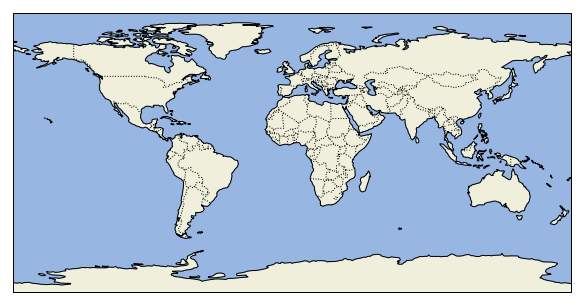

In [26]:
# And now... Exploring matplotlib.basemap
# Following https://www.youtube.com/watch?v=iPJjtU7OFSQ
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1, 1, 1, projection=crss.PlateCarree())
ax.add_feature(cfeat.LAND)
ax.add_feature(cfeat.OCEAN)
ax.add_feature(cfeat.COASTLINE)
ax.add_feature(cfeat.BORDERS, linestyle=':')
# ax.add_feature(cfeat.LAKES, alpha=0.5)
# ax.add_feature(cfeat.RIVERS)

# ax.set_extent((-120, -70, 20, 50))

In [28]:
# Setting colours to countries.
# Using https://matthewkudija.com/blog/2018/05/25/country-maps/
# as reference.

def plot_countries(df, projection, colors, annotation, title, edgecolor):
    # Basic map shared for 
    ax = plt.axes(projection=projection)
    ax.add_feature(cartography.feature.OCEAN, facecolor='white')
    ax.outline_patch.set_edgecolor(edgecolor)
    
    # Loading in data for country borders
    shpfilename = shpreader.natural_earth(
        resolution='110m',
        category='cultural',
        name=' admin_0_countries')
    
    # Read data from natural_earth.
    reader = shpreader.Reader(shpfilename)
    # Get countries.
    countries = reader.records()
    # Get values from the dataframe.
    values = list(df[title].unique())
    
    for country in countries:
        # See https://www.naturalearthdata.com/downloads/10m-cultural-vectors/10m-admin-0-countries/
        attribute = 'ADM0_A3'
        ADM0_03 = country.attributes['ADM0_a3']
        
        # Get classification
        try:
            classification = df.loc[country.attributes[attribute]][title]
        except:
            pass
        
        ax.add_geometries(country.geometry, crss.PlateCarree(),
                          facecolor=(colors[values.index(classification)]),
                          label=country.attributes[attribute],
                          edgecolor='#FFFFFF',
                          linewidth=0.25)
        
    # Legend
    import matplotlib.patches as mpatches
    handles = []
    for i in range(len(values)):
        handles.append(mpatches.Rectangle((0, 0), 1, 1, facecolor=colors[i]))
        plt.legend(handles, values,
                   loc='lower left', bbox_to_anchor=(0.025, -0.0), 
                   fancybox=True, frameon=False, fontsize=5)
        
    # annotate
    ax.annotate(annotation, xy=(0, 0),  xycoords='figure fraction',
            xytext=(0.0275, -0.025), textcoords='axes fraction',
            horizontalalignment='left', verticalalignment='center', fontsize=4,
            )
    
    plt.title(title, fontsize=8)

    title = 'maps/'+title+'.png'
    # plt.savefig(title, bbox_inches='tight', pad_inches=.2, dpi=300)
    # print('Saved: {}'.format(title))